 Dataset downloaded to: /home/prince/.cache/kagglehub/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min/versions/1
 Data Loaded Successfully!

--- Starting Training ---
 Training Complete.


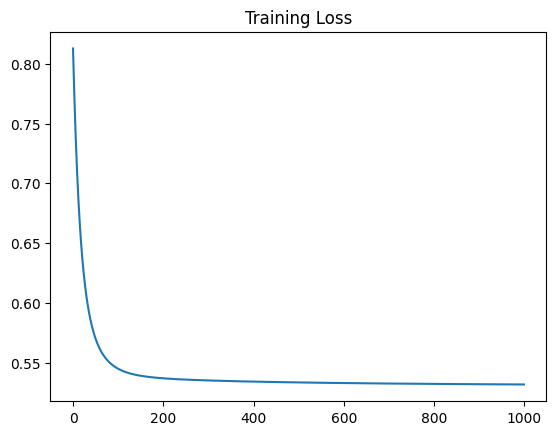

Test Accuracy: 0.7303


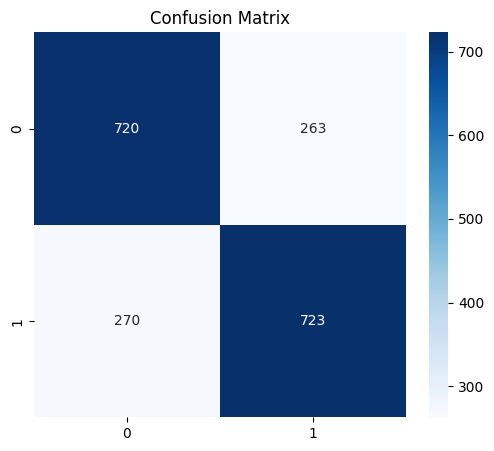

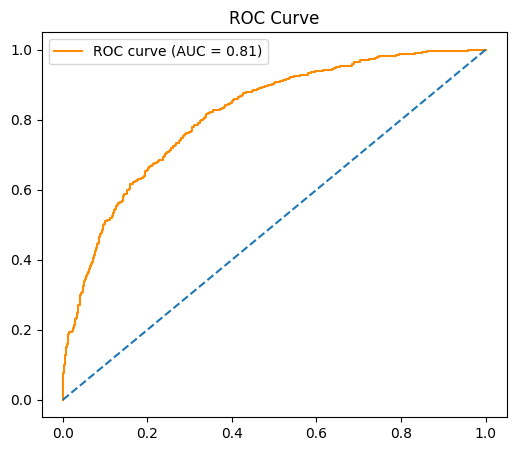


 Model saved as 'lol_logistic_model.pth'


/tmp/ipykernel_11028/2953599084.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weight', y='Feature', data=feature_importance, palette='viridis')


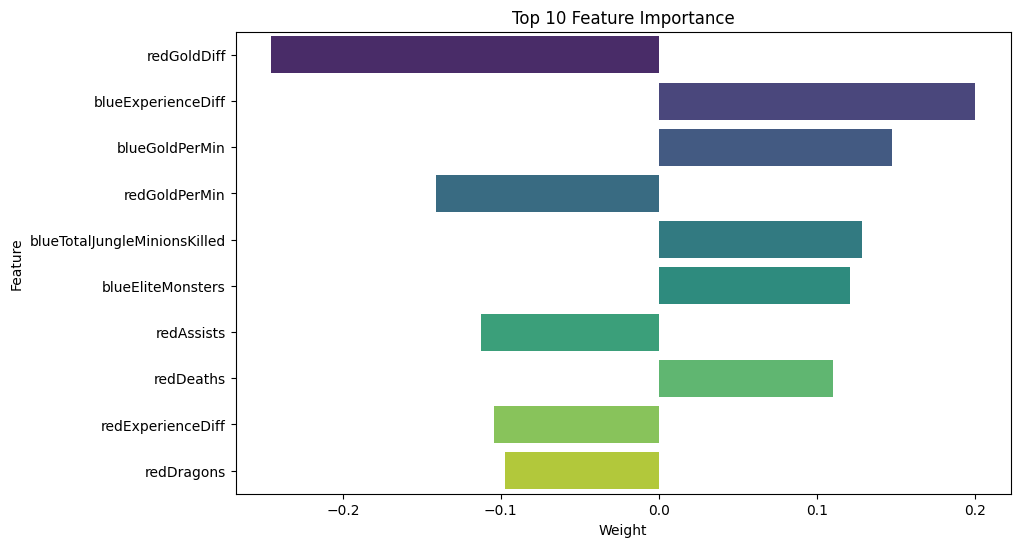

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report
import os

# 1.1: LOAD DATA AUTOMATICALLY
print("Downloading dataset via KaggleHub...")
# Download latest version
path = kagglehub.dataset_download("bobbyscience/league-of-legends-diamond-ranked-games-10-min")
print("Dataset downloaded to:", path)

# Find the csv file in the downloaded directory
csv_file = os.path.join(path, "high_diamond_ranked_10min.csv")
df = pd.read_csv(csv_file)
print(" Data Loaded Successfully!")

# Preprocessing
df_clean = df.drop(['gameId'], axis=1, errors='ignore')
X = df_clean.drop('blueWins', axis=1)
y = df_clean['blueWins']

# Split Data (80% Train, 20% Test)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Convert to Tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train_raw.values, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test_raw.values, dtype=torch.float32).view(-1, 1)

# 1.2: DEFINE MODEL
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

input_dim = X_train.shape[1]
model = LogisticRegressionModel(input_dim)

# 1.3: TRAIN MODEL
print("\n--- Starting Training ---")
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

loss_history = []
for epoch in range(1000):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())

print(" Training Complete.")
plt.plot(loss_history)
plt.title('Training Loss')
plt.show()

# 1.4 & 1.5: EVALUATION & VISUALIZATION
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test)
    y_pred_cls = y_pred_probs.round()

# Accuracy
acc = accuracy_score(y_test, y_pred_cls)
print(f"Test Accuracy: {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_cls)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()
plt.title('ROC Curve')
plt.show()

# 1.6: SAVE MODEL
torch.save(model.state_dict(), 'lol_logistic_model.pth')
print("\n Model saved as 'lol_logistic_model.pth'")

# 1.8: FEATURE IMPORTANCE
weights = model.linear.weight.detach().numpy()[0]
feature_importance = pd.DataFrame({'Feature': X.columns, 'Weight': weights, 'Abs': np.abs(weights)})
feature_importance = feature_importance.sort_values(by='Abs', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x='Weight', y='Feature', data=feature_importance, palette='viridis')
plt.title('Top 10 Feature Importance')
plt.show()

In [3]:
# 1.7: HYPERPARAMETER TUNING
print("\n--- 1.7 Tuning Learning Rate ---")
learning_rates = [0.001, 0.01, 0.1, 0.5]
results = {}

for lr in learning_rates:
    # Create a fresh model for each run so they don't share weights
    temp_model = LogisticRegressionModel(input_dim)
    temp_optimizer = optim.SGD(temp_model.parameters(), lr=lr)
    temp_criterion = nn.BCELoss()
    
    # Train for fewer epochs just to test speed/convergence
    for epoch in range(500): 
        outputs = temp_model(X_train)
        loss = temp_criterion(outputs, y_train)
        temp_optimizer.zero_grad()
        loss.backward()
        temp_optimizer.step()
        
    results[lr] = loss.item()
    print(f"LR: {lr} | Final Loss: {loss.item():.4f}")

best_lr = min(results, key=results.get)
print(f" Best Learning Rate found: {best_lr}")


--- 1.7 Tuning Learning Rate ---
LR: 0.001 | Final Loss: 0.5633
LR: 0.01 | Final Loss: 0.5331
LR: 0.1 | Final Loss: 0.5292
LR: 0.5 | Final Loss: 0.5289
Best Learning Rate found: 0.5
